# 総合実験（３日目）

## 〜 IPython Notebook (Jupyter Notebook)を使った多変量解析 〜

### IPython Notebook とは
* Python という名のプログラミング言語が使えるプログラミング環境。計算コードと計算結果を同じ場所に時系列で保存できるので、実験系における実験ノートのように、いつどんな処理を行って何を得たのか記録して再現するのに便利。
* [Jupyter Notebook（IPython）のインストールと始め方](http://www.task-notes.com/entry/20151129/1448794509)
* [小寺研究室](https://github.com/maskot1977/-/blob/master/L1%E3%82%BC%E3%83%9F2015%E5%B0%8F%E5%AF%BA%E7%A0%94%E7%A9%B6%E5%AE%A4.pptx.pdf) では、MacOSX上で右記のようにセットアップして使っています。> [環境構築](https://sites.google.com/site/masaakikotera/8-python/8-1-huan-jing-gou-zhu)

### 前回の復習
* 前回の内容を忘れてしまった人は[総合実験（２日目）](http://nbviewer.jupyter.org/github/maskot1977/ipython_notebook/blob/master/%E7%B7%8F%E5%90%88%E5%AE%9F%E9%A8%93%EF%BC%92%E6%97%A5%E7%9B%AE.ipynb) を見てください。

### 本実習スタート
* 本実習では多変量解析のうち主成分分析（PCA; Principal Component Analysis）を行ないます。
   * 主成分分析を知らない人は、右記のリンク参照→ [10分でわかる主成分分析(PCA)](http://www.slideshare.net/takanoriogata1121/10pca-49324044) ・ [主成分分析](http://www.yasunaga-lab.bio.kyutech.ac.jp/EosJ/index.php/%E4%B8%BB%E6%88%90%E5%88%86%E5%88%86%E6%9E%90)
* 各自の画面中の IPython Notebook のセルに順次入力して（コピペ可）、「Shift + Enter」してください。
* 最後に、課題を解いてもらいます。課題の結果を、指定する方法で指定するメールアドレスまで送信してください。

### まずは基本統計量を計算する関数の作成から

In [1]:
# 平均値を求める関数
def average(data):
    sum = 0.0
    n = 0.0
    for x in data:
        sum += x
        n += 1.0
    return sum / n

In [2]:
# 分散を求める関数
def dispersion(data):
    ave = average(data)
    accum = 0.0
    n = 0.0
    for x in data:
        accum += (x - ave) ** 2.0
        n += 1.0
    return accum / n

In [3]:
# 標準偏差を求める関数
import math
standard_deviation = lambda data: math.sqrt(dispersion(data))

In [4]:
# リストの正規化をする（Z値に変換する）関数
def normalize(data):
    ave = average(data)
    std = standard_deviation(data)
    list = []
    for x in data:
        list.append((x - ave) / (std / float(len(data))))
    return list

In [5]:
# リストのリストの正規化をする（Z値に変換する）関数
def normalize2(data):
    list = []
    for x in data:
        list.append(normalize(x))
    return list

### 計算に必要ないろんなライブラリのインポート

In [6]:
# 図やグラフを図示するためのライブラリをインポートする。
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import pandas as pd # データフレームワーク処理のライブラリをインポート
from pandas.tools import plotting # 高度なプロットを行うツールのインポート

In [8]:
import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器

In [9]:
import numpy as np #数値計算用ライブラリ

In [10]:
# URL によるリソースへのアクセスを提供するライブラリをインポートする。
import urllib

### 実データ解析開始
* データをダウンロードし、まずはデータの全体像を把握します。

In [11]:
# ウェブ上のリソースを指定する
url = 'https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/sake_dataJ.txt'
# 指定したURLからリソースをダウンロードし、名前をつける。
urllib.urlretrieve(url, 'sake_dataJ.txt')

('sake_dataJ.txt', <httplib.HTTPMessage instance at 0x1164e9ab8>)

In [12]:
df = pd.read_csv('sake_dataJ.txt', sep='\t', na_values=".") # データの読み込み
pd.DataFrame(df).head() # 先頭N行を表示する。カラムのタイトルも確認する。

,Pref,Sake,Shochu,Bear,Wine,Whisky
0,Hokkaido,46476000,50642000,315300000,10488000,9749000
1,Aomori,17273000,11503000,83164000,1774000,3122000
2,Iwate,17120000,10220000,67803000,1458000,1870000
3,Miyagi,27859000,11768000,109850000,2824000,5049000
4,Akita,24153000,6240000,67894000,1242000,2099000


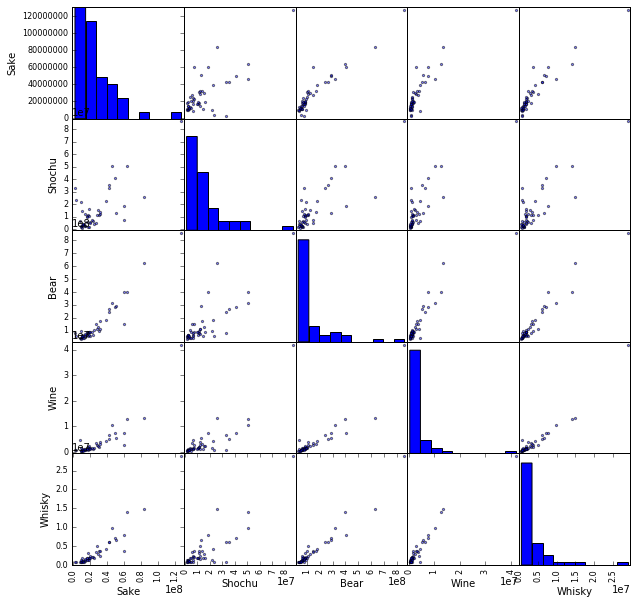

In [13]:
# 下記の関数にカラム名を入力すれば、指定した全てのカラムのヒストグラムと散布図が表示されます。
plotting.scatter_matrix(df[['Sake', 'Shochu', 'Bear', 'Wine', 'Whisky']], figsize=(10, 10)) 
plt.show()

上図を「図1」と呼ぶことにします。課題1と4で、似たような図を作成してもらいます。

### 主成分分析
#### 行をエントリとし、列を説明変数とする場合。

In [14]:
# 表形式のデータを、PCAにかけられる形に整形する。
# 行をエントリとし、列を説明変数とする場合。
x_labels = []
y_labels = []
data1 = []
for i, line in enumerate(open('sake_dataJ.txt')):
    if i == 0:
        a = line.strip().split("\t")
        x_labels = []
        for j, val in enumerate(a):
            if j == 0:
                continue
            else:
                x_labels.append(val)
    else:
        a = line.strip().split("\t")
        b = []
        for j, val in enumerate(a):
            if j == 0:
                y_labels.append(val)
            else:
                b.append(float(val))
        data1.append(b)
data1 = normalize2(data1)

In [15]:
#主成分分析の実行
pca = PCA()
pca.fit(data1)

PCA(copy=True, n_components=None, whiten=False)

In [16]:
# 因子負荷量の確認。左から順に第一変数、第二変数、、、
# 上から順に因子1、因子２、、、
pd.DataFrame(list(pca.components_), columns=x_labels)

,Sake,Shochu,Bear,Wine,Whisky
0,0.665066,-0.745030,0.020380,0.015191,0.044392
1,0.595199,0.492514,-0.291951,-0.423517,-0.372246
2,-0.033083,-0.000164,-0.030030,-0.674053,0.737331
3,0.048279,0.048577,-0.844658,0.407499,0.340303
4,0.447214,0.447214,0.447214,0.447214,0.447214


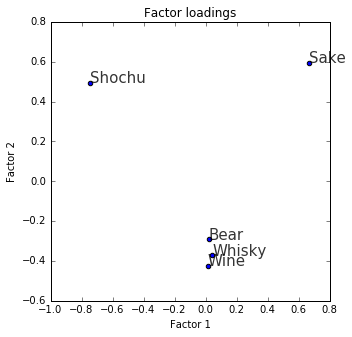

In [17]:
# それぞれの因子にどの説明変数がどの程度用いられているか図示する
plt.figure(figsize=(5, 5))
for x, y, name in zip(pca.components_[0], pca.components_[1], x_labels):
    plt.text(x, y, name, alpha=0.8, size=15)
plt.scatter(pca.components_[0], pca.components_[1])
plt.title("Factor loadings")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.show()

In [18]:
# 主成分に対する因子の寄与率を確認。左から順に第一主成分、第二主成分、、、
list(pca.explained_variance_ratio_)

[0.84883499643508986,
 0.13109085939363213,
 0.013441153902092553,
 0.006632990269185365,
 1.097158765092042e-31]

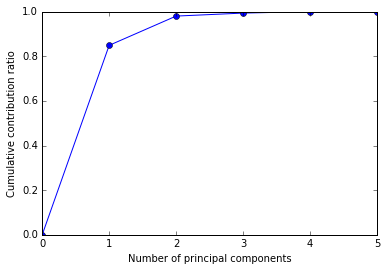

In [19]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution ratio")
plt.show()

In [20]:
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(data1)

In [21]:
# 次元圧縮後のデータ。左から順に第一主成分、第二主成分、、、
pd.DataFrame(feature, index=y_labels)

,0,1,2,3,4
Hokkaido,-1.110409,-0.360847,-0.005956,-0.081387,-1.848328e-16
Aomori,-0.333849,0.009345,0.142182,-0.121610,-3.301751e-16
Iwate,-0.056292,0.503782,0.018778,-0.158425,-6.492096e-16
Miyagi,0.408308,0.103275,0.165782,-0.058181,-6.292635e-16
Akita,1.443781,0.962598,0.042480,0.048677,-3.417578e-16
Yamagata,1.231049,0.744283,0.052815,0.017058,-1.316482e-16
Fukushima,0.860825,0.674256,0.124998,-0.052539,-2.086859e-16
Ibaraki,0.068851,0.176213,0.015612,-0.105348,-4.502962e-16
Tochigi,-0.042050,0.188377,0.022389,-0.118697,-4.399736e-17
Gunma,-0.635379,0.424675,-0.061466,-0.186559,-5.561106e-16


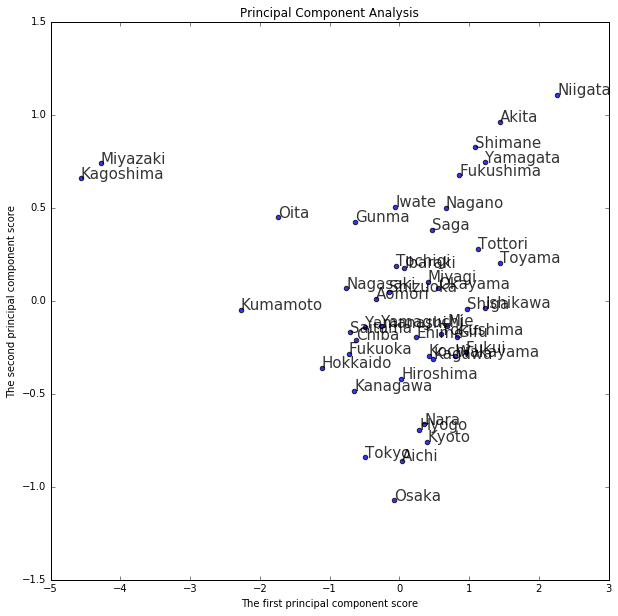

In [22]:
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(10, 10))
for x, y, name in zip(feature[:, 0], feature[:, 1], y_labels):
    plt.text(x, y, name, alpha=0.8, size=15)
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8)
plt.title("Principal Component Analysis")
plt.xlabel("The first principal component score")
plt.ylabel("The second principal component score")
plt.show()

上図を「図2」と呼ぶことにします。課題2と5で、似たような図を作成してもらいます。
#### 列をエントリとし、行を説明変数とする場合。

In [23]:
# 表形式のデータを、PCAにかけられる形に整形する。
# 列をエントリとし、行を説明変数とする場合。
x_labels = []
y_labels = []
data2 = []
for i, line in enumerate(open('sake_dataJ.txt')):
    if i == 0:
        a = line.strip().split("\t")
        y_labels = []
        for j, val in enumerate(a):
            if j == 0:
                continue
            else:
                y_labels.append(val)
                data2.append([])
    else:
        a = line.strip().split("\t")
        b = []
        for j, val in enumerate(a):
            if j == 0:
                x_labels.append(val)
            else:
                data2[j - 1].append(float(val))
data2 = normalize2(data2)

In [24]:
#主成分分析の実行
pca = PCA()
pca.fit(data2)

PCA(copy=True, n_components=None, whiten=False)

In [25]:
# 因子負荷量の確認。左から順に第一変数、第二変数、、、
# 上から順に因子1、因子２、、、
pd.DataFrame(pca.components_, columns=x_labels)

,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,Gunma,...,Kagawa,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima
0,0.275489,0.039741,0.037039,-0.039969,-0.059777,-0.040114,-0.055869,0.000841,0.022621,0.091066,...,-0.016326,-0.017543,-0.014956,0.128462,0.008461,0.076744,0.233482,0.136635,0.306588,0.432275
1,-0.116942,0.040067,0.022673,0.024537,-0.008161,0.062057,-0.066715,-0.093032,-0.003837,-0.024243,...,0.100946,0.024591,0.084554,-0.276205,0.068738,0.005495,-0.053999,0.027990,-0.025145,-0.120296
2,-0.046757,-0.028055,0.040584,0.060954,0.147034,0.100469,0.164137,0.094025,0.026149,0.056845,...,-0.050275,-0.029234,-0.057383,-0.037363,-0.007293,-0.041365,-0.130533,-0.056618,-0.114217,-0.159604
3,0.149324,0.223728,0.034813,0.428843,0.075589,0.152153,0.254214,-0.019647,-0.001778,-0.096611,...,-0.002780,-0.045749,0.013399,-0.059985,-0.036428,-0.002992,-0.148868,0.124259,-0.102680,-0.163846
4,-0.172858,-0.207267,-0.054197,-0.083138,-0.030749,0.071060,-0.057463,-0.006176,-0.013600,0.038431,...,-0.129569,0.279367,-0.017207,0.214137,-0.035018,-0.128023,-0.260437,-0.016798,0.032803,0.069383


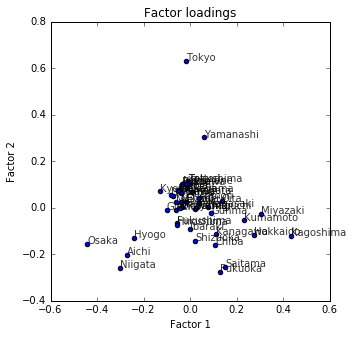

In [26]:
# それぞれの因子にどの説明変数がどの程度用いられているか図示する
plt.figure(figsize=(5, 5))
for x, y, name in zip(pca.components_[0], pca.components_[1], x_labels):
    plt.text(x, y, name, alpha=0.8, size=10)
plt.scatter(pca.components_[0], pca.components_[1])
plt.title("Factor loadings")
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.show()

In [27]:
# 主成分に対する因子の寄与率を確認。左から順に第一主成分、第二主成分、、、
list(pca.explained_variance_ratio_)

[0.65580254639595692,
 0.22004551664752053,
 0.089448901881823112,
 0.034703035074699393,
 1.962690226154014e-32]

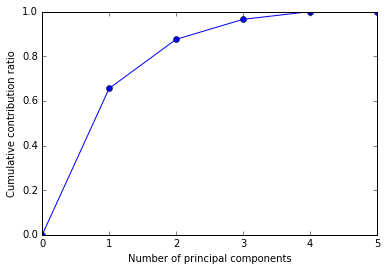

In [28]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution ratio")
plt.show()

In [29]:
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(data2)

In [30]:
# 次元圧縮後のデータ。左から順に第一主成分、第二主成分、、、
pd.DataFrame(feature, index=y_labels)

,0,1,2,3,4
Sake,-83.478816,-41.240646,38.205369,-3.137163,-9.606462e-15
Shochu,139.596385,-32.110658,6.807571,-1.155559,8.106997e-15
Bear,-42.598445,-23.181311,-46.321043,-14.139350,-1.285136e-13
Wine,5.375823,77.307076,11.970727,-14.610832,-1.034849e-13
Whisky,-18.894947,19.225538,-10.662626,33.042904,2.958189e-13


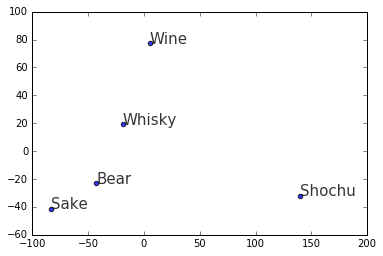

In [31]:
# 第一主成分と第二主成分でプロットする
#plt.figure(figsize=(10, 10))
for x, y, name in zip(feature[:, 0], feature[:, 1], y_labels):
    plt.text(x, y, name, alpha=0.8, size=15)
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8)
plt.show()

上図を「図3」と呼ぶことにします。課題3で、似たような図を作成してもらいます。

----------
## 課題
新しいノートを開いて、以下の課題を解いてください。

* __課題1__：下記リンクのデータを用い、図1のようなヒストグラムと散布図を描いてください。
   * https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/sports_dataJt.txt
   
   ここでは、以下の列を使います。
       * 'Student' : 学生のID番号
       * '50mRun' : 50m走
       * 'longjump': 走り幅跳び
       * 'handball': ハンドボール投げ
       * 'chinning': 懸垂
       * 'sidestep': 反復横跳び
       * 'vertump': 垂直跳び
       * 'back': 背筋力
       * 'grip': 握力（両手平均）
       * 'backward': 上体そらし
       * 'forward' : 立位体前屈
       * 'stepping': 踏み台昇降

* __課題２__：上記データの主成分分析を行ない、図2のような散布図を作成し、特徴的な成績を残している学生のIDを述べてください。また、その特徴についても考察してください。

* __課題３__：同様に、上記データの主成分分析を行ない、図３のような散布図を作成し、各項目（50m走など）間の関係について考察してください。

* __課題４__：下記リンクのデータを用い、図1のようなヒストグラムと散布図を描いてください。
   * https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/sbnote_dataJt.txt
   
      ここでは、以下の列を使います。
       * 'Note' : スイスフラン紙幣のID番号
       * 'length' : 横幅長
       * 'left': 左縦幅長
       * 'right': 右縦幅長
       * 'bottom': 下枠内長
       * 'top': 上枠内長
       * 'diagonal': 対角長

* __課題５__：上記データの主成分分析を行ない、図2のような散布図を作成し、分布の特徴について考察してください。

以上の結果を [自分の氏名].ipynb ファイルとして保存し、指定したアドレスまでメールしてください。メールタイトルは「総合実験3日目」とし、メール本文に学籍番号と氏名を明記のこと。